In [55]:
!pip -q install --upgrade pip
!pip -q install jsonlines
import jsonlines

In [56]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()
BUCKET = sess.default_bucket()
PREFIX = 'input'

arn:aws:iam::587793847503:role/service-role/AmazonSageMaker-ExecutionRole-20210210T223063
CPU times: user 196 ms, sys: 0 ns, total: 196 ms
Wall time: 296 ms


In [57]:
!wget http://aws-tc-largeobjects.s3-us-west-2.amazonaws.com/DIG-TF-200-MLBEES-10-EN/dataset.zip 
!unzip -qo dataset.zip

--2021-02-12 17:32:21--  http://aws-tc-largeobjects.s3-us-west-2.amazonaws.com/DIG-TF-200-MLBEES-10-EN/dataset.zip
Resolving aws-tc-largeobjects.s3-us-west-2.amazonaws.com (aws-tc-largeobjects.s3-us-west-2.amazonaws.com)... 52.218.219.33
Connecting to aws-tc-largeobjects.s3-us-west-2.amazonaws.com (aws-tc-largeobjects.s3-us-west-2.amazonaws.com)|52.218.219.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70375947 (67M) [application/x-zip-compressed]
Saving to: ‘dataset.zip.2’

dataset.zip.2       100%[===================>]  67.12M  13.3MB/s    in 5.5s    

2021-02-12 17:32:27 (12.3 MB/s) - ‘dataset.zip.2’ saved [70375947/70375947]



In [58]:
!unzip -l dataset.zip.2 | tail -20

   251027  05-15-2019 19:21   9530124.jpg
   110561  05-15-2019 19:21   9542264.jpg
   312354  05-15-2019 19:21   9543188.jpg
    76903  05-15-2019 19:21   9637165.jpg
    48663  05-15-2019 19:21   9765741.jpg
    66393  05-15-2019 19:21   9787032.jpg
   273392  05-22-2019 21:58   output.manifest
        0  06-01-2019 05:51   test/
    83438  06-01-2019 05:51   test/22427594.jpg
   152133  06-01-2019 05:51   test/22469656.jpg
   205930  06-01-2019 05:51   test/22544384.jpg
   137755  06-01-2019 05:51   test/22673445.jpg
   124565  06-01-2019 05:51   test/22741822.jpg
    39502  06-01-2019 05:51   test/22774999.jpg
    39086  06-01-2019 05:51   test/22775000.jpg
   149389  06-01-2019 05:51   test/22901964.jpg
   103322  06-01-2019 05:51   test/22971237.jpg
   109178  06-01-2019 05:51   test/23086755.jpg
---------                     -------
 70635014                     512 files


In [59]:
!aws s3 sync --exclude="*" --include="[0-9]*.jpg" . s3://$BUCKET/$PREFIX/

In [62]:
import json
import numpy as np

with jsonlines.open('output.manifest', 'r') as reader:
    lines = list(reader)
    # Shuffle data in place.
    np.random.shuffle(lines)
    
dataset_size = len(lines)
num_training_samples = round(dataset_size*0.8)

train_data = lines[:num_training_samples]
validation_data = lines[num_training_samples:]

augmented_manifest_filename_train = 'train.manifest'

with open(augmented_manifest_filename_train, 'w') as f:
    for line in train_data:
        f.write(json.dumps(line))
        f.write('\n')

augmented_manifest_filename_validation = 'validation.manifest'

with open(augmented_manifest_filename_validation, 'w') as f:
    for line in validation_data:
        f.write(json.dumps(line))
        f.write('\n')
        
print(f'training samples: {num_training_samples}, validation samples: {len(lines)-num_training_samples}')

training samples: 400, validation samples: 100


In [63]:

pfx_training = PREFIX + '/training' if PREFIX else 'training'
# Defines paths for use in the training job request.
s3_train_data_path = 's3://{}/{}/{}'.format(BUCKET, pfx_training, augmented_manifest_filename_train)
s3_validation_data_path = 's3://{}/{}/{}'.format(BUCKET, pfx_training, augmented_manifest_filename_validation)

!aws s3 cp train.manifest s3://$BUCKET/$pfx_training/
!aws s3 cp validation.manifest s3://$BUCKET/$pfx_training/
    


upload: ./train.manifest to s3://sagemaker-us-east-1-587793847503/input/training/train.manifest
upload: ./validation.manifest to s3://sagemaker-us-east-1-587793847503/input/training/validation.manifest


In [64]:
import time
import sagemaker
import boto3

client = boto3.client('sagemaker')
role = sagemaker.get_execution_role()
sess = sagemaker.Session()

# training_image = sagemaker.amazon.amazon_estimator.get_image_uri(boto3.Session().region_name, 'object-detection', repo_version = 'latest')
# print(training_image)
training_image = sagemaker.image_uris.retrieve('object-detection',boto3.Session().region_name)

s3_output_path = 's3://{}/{}/output'.format(BUCKET, pfx_training)


timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
training_job_name = 'bees-detection-resnet' + timestamp

training_params = {
     "AlgorithmSpecification": {
            
            "TrainingImage": training_image,
            "TrainingInputMode": "Pipe"
        },
        "RoleArn": role,
        "OutputDataConfig": {
            "S3OutputPath": s3_output_path
        },
        "ResourceConfig": {
            "InstanceCount": 1,
            "InstanceType": "ml.p3.2xlarge",
            "VolumeSizeInGB": 50
        },
        "TrainingJobName": training_job_name,
        "HyperParameters": {  
            "base_network": "resnet-50",
            "use_pretrained_model": "1",
            "num_classes": "1",
            "mini_batch_size": "1",
            "epochs": "100",
            "learning_rate": "0.001",
            "lr_scheduler_step": "",
            "lr_scheduler_factor": "0.1",
            "optimizer": "sgd",
            "momentum": "0.9",
            "weight_decay": "0.0005",
            "overlap_threshold": "0.5",
            "nms_threshold": "0.45",
            "image_shape": "300",
            "label_width": "350",
            "num_training_samples": str(num_training_samples)
        },
        "StoppingCondition": {
            "MaxRuntimeInSeconds": 86400
        },
        "InputDataConfig": [
            {
                "ChannelName": "train",
                "DataSource": {
                    "S3DataSource": {
                        "S3DataType": "AugmentedManifestFile",  
                        "S3Uri": s3_train_data_path,
                        "S3DataDistributionType": "FullyReplicated",
                        "AttributeNames": ['source-ref', 'bees-500']
                    }
                },
                "ContentType": "application/x-recordio",
                "RecordWrapperType": "RecordIO",
                "CompressionType": "None"
            },
            {
                "ChannelName": "validation",
                "DataSource": {
                    "S3DataSource": {
                        "S3DataType": "AugmentedManifestFile",  
                        "S3Uri": s3_validation_data_path,
                        "S3DataDistributionType": "FullyReplicated",
                        "AttributeNames": ['source-ref', 'bees-500']
                    }
                },
                "ContentType": "application/x-recordio",
                "RecordWrapperType": "RecordIO",
                "CompressionType": "None"
            }
        ]
}

client = boto3.client(service_name='sagemaker')
client.create_training_job(**training_params)

status = client.describe_training_job(TrainingJobName=training_job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))


Training job current status: InProgress


In [65]:
import boto3
client = boto3.client('sagemaker')

training_job_name = training_job_name

training_info = client.describe_training_job(TrainingJobName=training_job_name)

print("Training job status: ", training_info['TrainingJobStatus'])
print("Secondary status: ", training_info['SecondaryStatus'])

Training job status:  Completed
Secondary status:  Completed


In [81]:
import time
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
model_name = training_job_name + '-model' + '1'

training_image = training_info['AlgorithmSpecification']['TrainingImage']
model_data = training_info['ModelArtifacts']['S3ModelArtifacts']

primary_container = {
    'Image': training_image,
    'ModelDataUrl': model_data,
}

from sagemaker import get_execution_role

role = get_execution_role()

create_model_response = client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

arn:aws:sagemaker:us-east-1:587793847503:model/bees-detection-resnet-2021-02-12-17-35-45-model1


In [82]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = training_job_name + '-epc' + "1"
endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.t2.medium',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration name: bees-detection-resnet-2021-02-12-17-35-45-epc1
Endpoint configuration arn:  arn:aws:sagemaker:us-east-1:587793847503:endpoint-config/bees-detection-resnet-2021-02-12-17-35-45-epc1


In [85]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = training_job_name + '-ep' + '1'
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = client.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

# get the status of the endpoint
response = client.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))

Endpoint name: bees-detection-resnet-2021-02-12-17-35-45-ep1
EndpointArn = arn:aws:sagemaker:us-east-1:587793847503:endpoint/bees-detection-resnet-2021-02-12-17-35-45-ep1
EndpointStatus = Creating


In [86]:
import glob
test_images = glob.glob('test/*')
print(*test_images, sep="\n")

test/22673445.jpg
test/22901964.jpg
test/22427594.jpg
test/22469656.jpg
test/23086755.jpg
test/22544384.jpg
test/22741822.jpg
test/22774999.jpg
test/22775000.jpg
test/22971237.jpg


In [87]:
def prediction_to_bbox_data(image_path, prediction):
    class_id, confidence, xmin, ymin, xmax, ymax = prediction
    width, height = Image.open(image_path).size
    bbox_data = {'class_id': class_id,
               'height': (ymax-ymin)*height,
               'width': (xmax-xmin)*width,
               'left': xmin*width,
               'top': ymin*height}
    return bbox_data

In [89]:
import os
import boto3
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
from itertools import cycle

def show_annotated_image(img_path, bboxes):
    im = np.array(Image.open(img_path), dtype=np.uint8)
    
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(im)

    colors = cycle(['r', 'g', 'b', 'y', 'c', 'm', 'k', 'w'])
    
    for bbox in bboxes:
        # Create a Rectangle patch
        rect = patches.Rectangle((bbox['left'],bbox['top']),bbox['width'],bbox['height'],linewidth=1,edgecolor=next(colors),facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

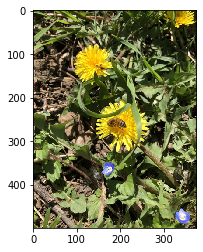

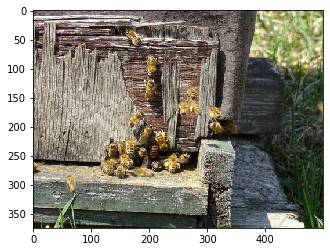

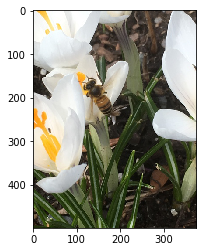

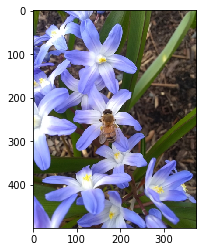

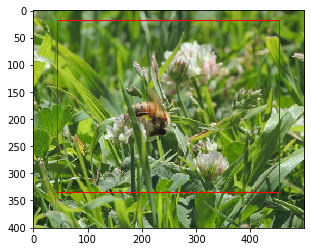

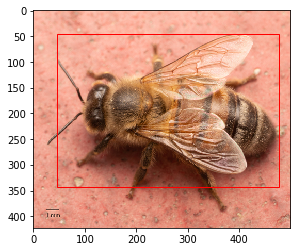

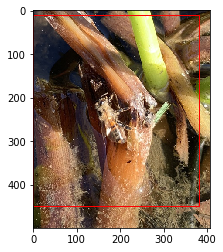

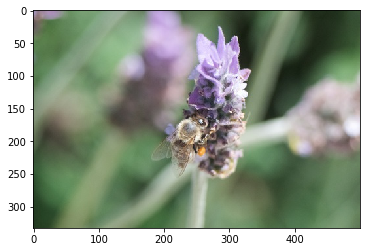

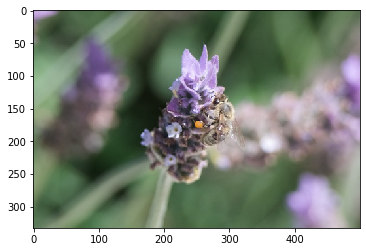

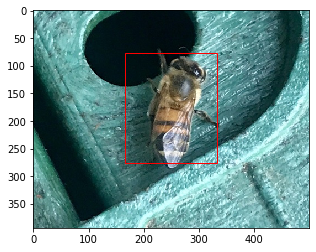

In [90]:
import matplotlib.pyplot as plt

endpoint_name='bees-detection-resnet-2021-02-12-17-35-45-ep1'

runtime_client = boto3.client('sagemaker-runtime')

# Call SageMaker endpoint to obtain predictions
def get_predictions_for_img(runtime_client, endpoint_name, img_path):
    with open(img_path, 'rb') as f:
        payload = f.read()
        payload = bytearray(payload)

    response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                       ContentType='application/x-image', 
                                       Body=payload)

    result = response['Body'].read()
    result = json.loads(result)
    return result


# wait until the status has changed
client.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)
endpoint_response = client.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
if status != 'InService':
    raise Exception('Endpoint creation failed.')

for test_image in test_images:
    result = get_predictions_for_img(runtime_client, endpoint_name, test_image)
    confidence_threshold = .5
    best_n = 1
    # display the best n predictions with confidence > confidence_threshold
    predictions = [prediction for prediction in result['prediction'] if prediction[1] > confidence_threshold]
    predictions.sort(reverse=True, key = lambda x: x[1])
    bboxes = [prediction_to_bbox_data(test_image, prediction) for prediction in predictions[:best_n]]
    show_annotated_image(test_image, bboxes)

In [91]:
client.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '7fb4563b-91cc-424a-9c96-80020d32a52a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '7fb4563b-91cc-424a-9c96-80020d32a52a',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Fri, 12 Feb 2021 18:41:36 GMT'},
  'RetryAttempts': 0}}